In [1]:

%matplotlib inline
#matplotlib notebook
%config Completer.use_jedi = False
import matplotlib.pyplot as plt
import autograd.numpy as np  # Thinly-wrapped numpy
from autograd import grad    # The only autograd function you may ever need
import autograd.numpy.linalg as linalg
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# read in dataset1
dataset1_df = pd.read_csv('./datasets/dataset1.csv', header=0)
dataset1 = np.array(dataset1_df)
d1X, d1Y = dataset1[:, 0:4], dataset1[:, -1]
# split the data into training and testing 
# the training dataset has the first 1500 observation; 
# in practice, you should randomly shuffle before the split
d1_xtrain, d1_ytrain = d1X[0:1500, :], d1Y[0:1500]
# the testing dataset has the last 500
d1_xtest, d1_ytest = d1X[1500:, :], d1Y[1500:]

In [3]:
#adding ones for the bias term
d1_xtrain_dummy = np.column_stack((np.ones(d1_xtrain.shape[0]), d1_xtrain))
d1_xtest_dummy = np.column_stack((np.ones(d1_xtest.shape[0]), d1_xtest))

In [4]:
d1_xtrain_dummy.shape

(1500, 5)

In [5]:
def sigmoid(z):
    sig=1/(1+np.exp(-z))
    # hint: use np.exp(-z)
    return sig

In [6]:
def cross_entropy_loss(w, X, y):
    y_=X@w#predicted output
    sig=sigmoid(y_)
    loss=np.mean(-y*np.log(sig)-(1-y)*np.log(1-sig))#cross entropy loss
    return loss

In [7]:
def gradient_ce_loss(w, X, y):
    eps=10**(-6) #finite difference eps for dw parameter
    
    gradient=np.zeros(len(w))#initialise gradient vector
    
    for i in range(len(w)):
        e=np.zeros(len(w))
        e[i]=1
        
        #finite difference for every entry of the gradient vector
        gradient[i]=(cross_entropy_loss(w+e*eps,X,y)-cross_entropy_loss(w-e*eps,X,y))/(2*eps)
        
    return gradient

In [8]:
w_test=np.zeros(5)
gradient_ce_loss(w_test,d1_xtrain_dummy,d1_ytrain)# testing gradient

array([ 0.354     , -0.06044063,  0.03826493, -0.01434547,  0.02058552])

In [9]:
y_=sigmoid(d1_xtrain_dummy@w_test)
gradient=d1_xtrain_dummy.T@(y_-d1_ytrain)/y_.shape[0]
gradient #verifying that calculation of gradient is correct

array([ 0.354     , -0.06044063,  0.03826493, -0.01434547,  0.02058552])

In [10]:
def logistic_regression_train(X, y, gamma, tol= 1e-4, maxIters= 1000):
    n, d = X.shape 
    # initialise w0
    w0 = np.zeros(d)#initialise w0
    losses = []
    # loop until converge
    
    for i in range(maxIters):
        loss=cross_entropy_loss(w0, X, y)
        gradient=gradient_ce_loss(w0,X,y)
        w0 = w0 - gamma * gradient
        losses.append(loss)
        if i>=1:
            #checking difference of losses to stop training when it has reached the tolerance threshold
            if abs(losses[i]-losses[i-1])<=tol: 
                break
    return w0,losses

In [11]:
#gamma=0.5 was used, learning converges fast without danger of oscillation around the minimum

w0,losses=logistic_regression_train(d1_xtrain_dummy,d1_ytrain,0.5)

In [12]:
losses[len(losses)-1]

0.3408249764820776

Text(0, 0.5, 'loss')

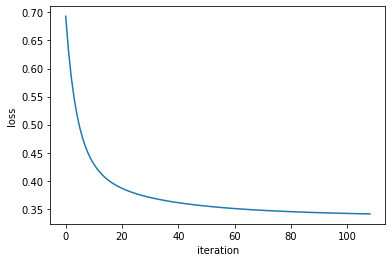

In [13]:
plt.plot(losses)
plt.xlabel("iteration")
plt.ylabel("loss")#learning curve plotted below

In [14]:
w0[1:len(w0)]#w parameters

array([ 1.47957075, -0.81836541,  0.31366602, -0.0427522 ])

In [15]:
w0[0]#bias

-2.059622242076009

In [16]:
def predict_logistic_regression(w, X = d1_xtest_dummy):
    n, d = X.shape 
    ## fill the rest of the method
    prediction=sigmoid(X@w)
    return prediction

In [17]:
label=np.round(predict_logistic_regression(w0))
accuracy=np.mean(label==d1_ytest)
accuracy

0.866

In [18]:
TN=np.sum(label[d1_ytest==0]==d1_ytest[d1_ytest==0])
TN

430

In [19]:
FP=len(d1_ytest[d1_ytest==0])-TN
FP

3

In [20]:
TP=np.sum(label[d1_ytest==1]==d1_ytest[d1_ytest==1])
TP

3

In [21]:
FN=np.sum(d1_ytest[d1_ytest==1])-TP
FN

64.0

In [22]:
accuracy=(TP+TN)/(TP+TN+FN+FP)
accuracy

0.866

In [23]:
TPR=TP/(TP+FN)
TPR

0.04477611940298507

In [24]:
FPR=FP/(FP+TN)
FPR

0.006928406466512702

In [25]:
Recall=TPR
Recall

0.04477611940298507

In [26]:
Precision=TP/(TP+FP)
Precision

0.5

In [27]:
np.mean(d1_ytest)

0.134

In [28]:
#Model has an overall accuracy of 86.6%, while it performs overall very well it is a very biased model
#The main reason for the bias is that only 13.4% of the data are positive scores
#As a result of the bias the model has a very poor Recall=TPR=4.48% score
# The model has a bad precision value of 50% and an excellent FPR rate of 0.69%

In [29]:
def gradient_ce_reg_loss(w, X, y,lam):
    eps=10**(-6)
    gradient=np.zeros(len(w))
    for i in range(len(w)):
        e=np.zeros(len(w))
        e[i]=1
        gradient[i]=(cross_entropy_loss(w+e*eps,X,y)+lam/2*(w[1:len(w)-1]+eps*e[1:len(e)-1])@(w[1:len(w)-1]
                     +eps*e[1:len(e)-1])-cross_entropy_loss(w-e*eps,X,y)
                     -lam/2*(w[1:len(w)-1]-eps*e[1:len(e)-1])@(w[1:len(w)-1]-eps*e[1:len(e)-1])
                    )/(2*eps)
                    
        
    return gradient

In [30]:
def logistic_regression_reg_train(X, y, gamma, lam = 1.0, tol= 1e-4, maxIters= 100):
    n, d = X.shape 
    # initialise w0
    w0 = np.zeros(d)
    
    losses = []
    # loop until converge
    for i in range(maxIters):
        loss=cross_entropy_loss(w0, X, y)+lam/2*w0[1:len(w0)-1]@w0[1:len(w0)-1]
        gradient=gradient_ce_reg_loss(w0,X,y,lam)
        w0 = w0 - gamma * gradient
        losses.append(loss)
        if i>=1:
            if abs(losses[i]-losses[i-1])<=tol:
                break
    return w0,losses

In [31]:
w0,losses=logistic_regression_reg_train(d1_xtrain_dummy,d1_ytrain,0.5,lam=0.03)

In [32]:
w0

array([-1.82128152,  0.78365004, -0.44476571,  0.16274252, -0.03688272])

Text(0, 0.5, 'loss')

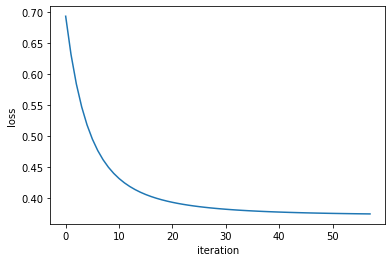

In [33]:
plt.plot(losses)
plt.xlabel("iteration")
plt.ylabel("loss")

In [34]:
label=np.round(predict_logistic_regression(w0))
label
np.mean(label==d1_ytest)

0.866

In [35]:
np.mean(d1_ytest)
#bad proportion of data

0.134

In [36]:
w0


array([-1.82128152,  0.78365004, -0.44476571,  0.16274252, -0.03688272])

In [37]:
losses[len(losses)-1]#training loss

0.3750398516071745

In [38]:
TN=np.sum(label[d1_ytest==0]==d1_ytest[d1_ytest==0])
TN

433

In [39]:
FP=len(d1_ytest[d1_ytest==0])-TN
FP

0

In [40]:
TP=np.sum(label[d1_ytest==1]==d1_ytest[d1_ytest==1])
TP

0

In [41]:
FN=np.sum(d1_ytest[d1_ytest==1])-TP
FN

67.0

In [42]:
accuracy=(TP+TN)/(TP+TN+FN+FP)
accuracy

0.866

In [43]:
TPR=TP/(TP+FN)
TPR

0.0

In [44]:
FPR=FP/(FP+TN)
FPR

0.0

In [45]:
Recall=TPR
Recall

0.0

In [46]:
Precision=TP/(TP+FP)
Precision

<ipython-input-46-b8e89c140ff6>:1: RuntimeWarning: invalid value encountered in scalar divide
  Precision=TP/(TP+FP)


nan

In [47]:
np.mean(d1_ytest)

0.134

In [48]:
#Model has an overall accuracy of 86.6% again , the model still remains a very biased model after Regularisation
#The main reason for the bias is that only 13.4% of the data are positive scores
#As a result of the bias the model has a very poor Recall=TPR=0% score
# The model has an undefined precision value since it never predicts Positive values with a FPR rate of 0%

In [49]:
lambda_set = np.logspace(-3, 0, 10)

loss_mean_lam=np.zeros(10)
loss_std_lam=np.zeros(10)

for i in range(10):    
    loss_history=np.zeros(5)
    for j in range(5):
        
        #splitting to validation and training datasets
        x_validation=d1_xtrain_dummy[j*300:300*(j+1)]
        x_train=np.vstack((d1_xtrain_dummy[0:j*300],d1_xtrain_dummy[(j+1)*300:len(d1_xtrain_dummy)]))
        y_validation=d1_ytrain[j*300:300*(j+1)]
        y_train=np.hstack((d1_ytrain[0:j*300],d1_ytrain[(j+1)*300:len(d1_ytrain)]))
        
        
        w0,losses=logistic_regression_reg_train(x_train,y_train,0.3,lam=lambda_set[i])
        
        loss_history[j]=cross_entropy_loss(w0, x_validation, y_validation)+lambda_set[i]/2*w0[1:len(w0)-1]@w0[1:len(w0)-1]#add loss of lambda
        
    loss_mean_lam[i]=np.mean(loss_history)
    loss_std_lam[i]=np.std(loss_history,ddof=1)


In [50]:
lambda_set

array([0.001     , 0.00215443, 0.00464159, 0.01      , 0.02154435,
       0.04641589, 0.1       , 0.21544347, 0.46415888, 1.        ])

Text(0, 0.5, 'CV MSE')

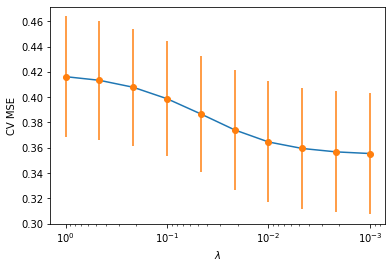

In [51]:
plt.plot(lambda_set,loss_mean_lam)
plt.xscale('log')
plt.gca().invert_xaxis()
plt.errorbar(lambda_set,loss_mean_lam,yerr = loss_std_lam,
             fmt ='o')
plt.xlabel(r'$\lambda$')
plt.ylabel('CV MSE')

In [52]:
#very high standard error for all lambda
#lambda=1 is the obvious choice
#method below could have been used if it was not obvious

In [53]:
#if value-standarderror>min+standarderror reject,
#choose highest lambda that satisfies(lambda_value-standarderror<min_lambda+standarderror_min_lambda)
list=[]
for i in range(1,10):
    if loss_mean_lam[i]-loss_std_lam[i]<=loss_mean_lam[0]+loss_std_lam[0]:
        list.append(i)

In [54]:
list

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [55]:
optimum_lambda=lambda_set[9]
optimum_lambda

1.0

In [56]:
def logistic_regression_reg_sgd_train(X, y, gamma, lam = 1.0, tol= 1e-4, maxIters= 100):
    n, d = X.shape 
    # initialise w0
    w0 = np.zeros(d)
    losses = []
    # loop until converge
        # for each observation (x^i, y^i) in (X, Y)
            # compute gradient and apply gradient descent
    for i in range(maxIters):
        loss=0
        rng = np.random.default_rng()
        rng.shuffle(X)
        rng.shuffle(y)
        
        for j in range(n):
            #adding loss for each datapoint
            loss+=cross_entropy_loss(w0, X[j], y[j])+lam/2*w0[1:len(w0)-1]@w0[1:len(w0)-1]
            gradient=gradient_ce_reg_loss(w0, X[j], y[j],lam)
            w0 = w0 - gamma * gradient
        losses.append(loss/n)#adding mean error of all observations
        if i>=1:
            #checking difference of losses to stop training when it has reached the tolerance threshold
            if abs(losses[i]-losses[i-1])<=tol:
                break
    return w0,losses

In [57]:
w0,losses=logistic_regression_reg_sgd_train(d1_xtrain_dummy,d1_ytrain,0.02,lam=0.03)

In [58]:
losses[len(losses)-1]#training loss

0.419812453208586

In [59]:
label=np.round(predict_logistic_regression(w0))

In [60]:
TN=np.sum(label[d1_ytest==0]==d1_ytest[d1_ytest==0])
TN

433

In [61]:
FP=len(d1_ytest[d1_ytest==0])-TN
FP

0

In [62]:
TP=np.sum(label[d1_ytest==1]==d1_ytest[d1_ytest==1])
TP

0

In [63]:
FN=np.sum(d1_ytest[d1_ytest==1])-TP
FN

67.0

In [64]:
accuracy=(TP+TN)/(TP+TN+FN+FP)
accuracy

0.866

In [65]:
TPR=TP/(TP+FN)
TPR

0.0

In [66]:
FPR=FP/(FP+TN)
FPR

0.0

In [67]:
Recall=TPR
Recall

0.0

In [68]:
Precision=TP/(TP+FP)
Precision

<ipython-input-68-b8e89c140ff6>:1: RuntimeWarning: invalid value encountered in scalar divide
  Precision=TP/(TP+FP)


nan

In [69]:
np.mean(d1_ytest)

0.134

In [70]:
cross_entropy_loss(w0, d1_xtest_dummy, d1_ytest)+0.03/2*w0[1:len(w0)-1]@w0[1:len(w0)-1]#testing loss

0.3940465178875034

In [71]:
#Model has an overall accuracy of 86.6% again , the model still remains a very biased model even with SGD
#The main reason for the bias is that only 13.4% of the data are positive scores
#As a result of the bias the model has still a very poor Recall=TPR=0% score
# The model has an undefined precision value since it never predicts Positive values and has a FPR rate of 0%

In [72]:
# read in dataset2
dataset2_df = pd.read_csv('./datasets/dataset2.csv', header=0)
dataset2 = np.array(dataset2_df)
d2X, d2Y = dataset2[:, 0], dataset2[:, -1]
# split the data into training and testing 
# the training dataset has the first 800 observation; 
# in practice, you should randomly shuffle before the split
d2_xtrain, d2_ytrain = d2X[0:800], d2Y[0:800]
# # the testing dataset has the last 500
d2_xtest, d2_ytest = d2X[800:], d2Y[800:]

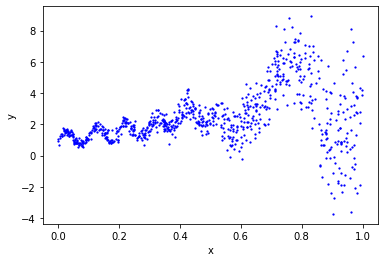

In [73]:
plt.scatter(d2_xtrain, d2_ytrain,  c ="blue", s=1.5)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [74]:
def phi_rbf(x, mu, s):
    return np.exp(-(x-mu)**2/(2*s))

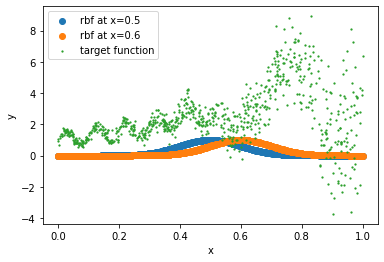

In [75]:
s=0.01
plt.scatter(d2_xtrain,phi_rbf(d2_xtrain,0.5,s))
plt.scatter(d2_xtrain,phi_rbf(d2_xtrain,0.6,s))
plt.scatter(d2_xtrain,d2_ytrain,s=1.5)
plt.xlabel("x")
plt.ylabel("y")
plt.legend(['rbf at x=0.5', 'rbf at x=0.6','target function'])
plt.show()
#the above parameters were chosen as a good fit
#with 11 locatons from x=0 to x=1 
#the plots of the rbf function at x=0.5 and x=0.6 are also shown below which do a good job at finding the variation of y

In [76]:
mus=np.linspace(0,1,11)

In [77]:
mus

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [78]:


def fixed_basis_rbf_reg(X, y, mus, s):
    matrix=np.zeros([X.size,len(mus)+1])#initialise phi matrix
    
    for i in range(len(mus)+1):
        for j in range(X.size):
            if i==0:
                matrix[j,i]=1#ones for bias 
            else:
                matrix[j,i]=phi_rbf(X[j],mus[i-1],s)# for weights
    
    w=np.linalg.inv(np.transpose(matrix)@matrix)@np.transpose(matrix)@y#normal equation
    
    return w

In [79]:
s=0.01

In [80]:
w=fixed_basis_rbf_reg(d2_xtrain, d2_ytrain, mus, s)

In [81]:
w

array([  1.01278609,   1.53863122,  -2.46536041,   3.36988626,
        -3.12262861,   3.68124644,  -1.35461154,   1.86425463,
        -3.50122576,  12.36151097, -11.46068886,   7.56383312])

In [82]:
def predict_rbf_reg(X, w, mus, s):
    #calculation phi_matrix again for the test_set dimensions
    matrix=np.zeros([X.size,len(mus)+1])
    
    for i in range(len(mus)+1):
        for j in range(X.size):
            if i==0:
                matrix[j,i]=1
            else:
                matrix[j,i]=phi_rbf(X[j],mus[i-1],s)
    y=matrix@w
    
    return y

In [83]:
y=predict_rbf_reg(d2_xtest, w, mus, s)

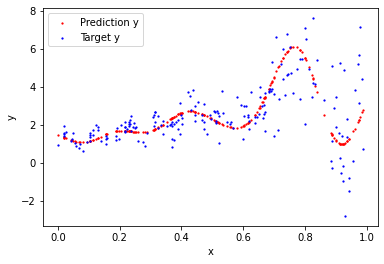

In [84]:
plt.scatter(d2_xtest,y,c ="red", s=1.5)
plt.scatter(d2_xtest, d2_ytest,  c ="blue", s=1.5)
plt.legend(['Prediction y','Target y'])
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [85]:
def phi_logistic(x, mu, s):
    return 1/(1+np.exp(-(x-mu)/(s)))

In [86]:
y_=phi_logistic(d2_xtrain,0.3,0.05)

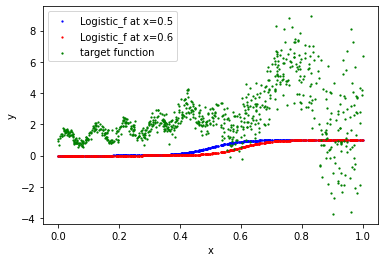

In [87]:
plt.scatter(d2_xtrain,phi_logistic(d2_xtrain,0.5,0.05),c='blue',s=1.5)
plt.scatter(d2_xtrain,phi_logistic(d2_xtrain,0.6,0.05),c='red',s=1.5)
plt.scatter(d2_xtrain,d2_ytrain,c='green',s=1.5)
plt.legend(['Logistic_f at x=0.5','Logistic_f at x=0.6','target function'])
plt.xlabel("x")
plt.ylabel("y")
plt.show()

#the above parameters were chosen as a good fit
#with 11 locatons from x=0 to x=1 
#the plots of the phi_logistic function at x=0.5 and x=0.6 are also shown below which do a good job at finding the variation of y

In [88]:
s=0.05

In [89]:
def fixed_basis_logistic_reg(X, y, mus, s):
    matrix=np.zeros([X.size,len(mus)+1])#initialise matrix
    
    for i in range(len(mus)+1):
        for j in range(X.size):
            if i==0:
                matrix[j,i]=1#for bias
            else:
                matrix[j,i]=phi_logistic(X[j],mus[i-1],s)#for weights
    
    w=np.linalg.inv(np.transpose(matrix)@matrix)@np.transpose(matrix)@y#normal equation
    
    
    return w

In [90]:
w=fixed_basis_logistic_reg(d2_xtrain, d2_ytrain, mus, s)

In [91]:
def predict_logistic_reg(X, w, mus, s):
    
    #calculate phi_matrix again for test set
    matrix=np.zeros([X.size,len(mus)+1])
    for i in range(len(mus)+1):
        for j in range(X.size):
            if i==0:
                matrix[j,i]=1
            else:
                matrix[j,i]=phi_logistic(X[j],mus[i-1],s)
    y=matrix@w
    
    return y

In [92]:
y=predict_logistic_reg(d2_xtest, w, mus, s)

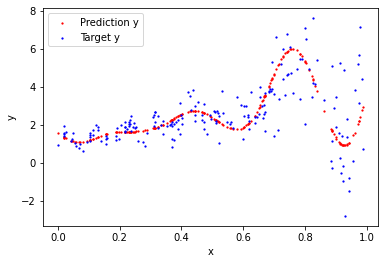

In [93]:
plt.scatter(d2_xtest,y,c ="red", s=1.5)
plt.scatter(d2_xtest, d2_ytest,  c ="blue", s=1.5)
plt.legend(['Prediction y','Target y'])
plt.xlabel("x")
plt.ylabel("y")
plt.show()

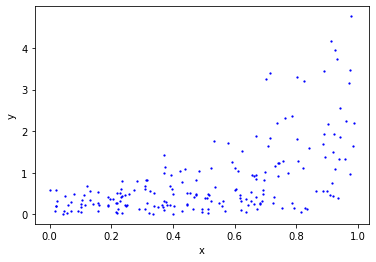

In [94]:
plt.scatter(d2_xtest, abs(d2_ytest-y),  c ="blue", s=1.5)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## References used below


 # https://www.stat.cmu.edu/~cshalizi/mreg/15/lectures/24/lecture-24--25.pdf
 # https://medium.com/datamotus/solving-the-problem-of-heteroscedasticity-through-weighted-regression-e4a22f1afa6b


In [95]:
#Maximum likehood estimation will be applied, since standard deviation is not constant only weights will be optimised
#with least squares method for every data point
#logistic functions are used to form the phi matrix
#minimise summation of (y_i-w@x_i)^2*1/(sigma_i)^2 where i is each observation 
#and sigma is the standard deviation at each data point.
#it was assumed that var(yi) is proportional to xi*sigma^2_general
#where sigma^2_general is a constant term
#this leads to the minimisation of the following:summation of (y_i-w@x_i)^2*1/x_i where i is the i_th observation 

def weighted_regression_loss(w, x, y,mus):
    
    #forming phi_matrix below 
    matrix=np.zeros([x.size,len(mus)+1])
    for i in range(len(mus)+1):
        for j in range(x.size):
            if i==0:
                matrix[j,i]=1
            else:
                matrix[j,i]=phi_logistic(x[j],mus[i-1],s)
                
    y_=matrix@w#prediction
    
    loss_squared=(y-y_)**2#squared error
    
    weighted_error=np.mean(loss_squared*1/x)
    return weighted_error

In [96]:
def gradient_ce_loss(w, X, y,mus):
    eps=10**(-6)
    gradient=np.zeros(len(w))
    for i in range(len(w)):
        e=np.zeros(len(w))
        e[i]=1
        gradient[i]=(weighted_regression_loss(w+e*eps,X,y,mus)-weighted_regression_loss(w-e*eps,X,y,mus))/(2*eps)
        
    return gradient

In [97]:
def weighted_regression_train(X, y, gamma,mus, tol= 1e-4, maxIters= 1000):
    #n, d = X.shape 
    # initialise w0
    w0 = np.zeros(len(mus)+1)
    losses = []
    # loop until converge
    for i in range(maxIters):
        loss=weighted_regression_loss(w0, X, y,mus)
        gradient=gradient_ce_loss(w0,X,y,mus)
        w0 = w0 - gamma * gradient
        losses.append(loss)
        if i>=1:
            if abs(losses[i]-losses[i-1])<=tol:
                break
    return w0,losses

In [98]:
w,losses=weighted_regression_train(d2_xtrain, d2_ytrain, 0.01,mus,maxIters= 20)

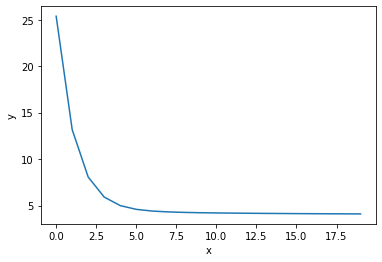

In [99]:
plt.plot(losses)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [100]:
y=predict_logistic_reg(d2_xtest, w, mus, s)

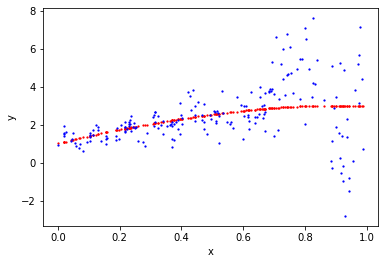

In [101]:
plt.scatter(d2_xtest,y,c ="red", s=1.5)
plt.scatter(d2_xtest, d2_ytest,  c ="blue", s=1.5)
plt.xlabel("x")
plt.ylabel("y")
plt.show()